# Coarse and high-resolution model plots

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import matplotlib.path as mpath

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [3]:
# this starts up a dask cluster to use all the cores you request:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43643 Dashboard: /proxy/35317/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [4]:
session = cc.database.create_session()
# Define experiment in database
expt01 = '01deg_jra55v13_ryf9091'
expt1 = '1deg_jra55_ryf9091_gadi'
# Setting start and end times
start_time = '2170-01-01'
end_time = '2170-12-31'

In [5]:
# Load velocity fields
v01 = cc.querying.getvar(expt01, 'v', session, ncfile='%daily%', start_time = start_time,end_time=end_time)
v01 = v01.sel(time = '2170-01-01', method = 'nearest')
u01 = cc.querying.getvar(expt01, 'u', session, ncfile='%daily%', start_time = start_time,end_time=end_time)
u01 = u01.sel(time = '2170-01-01', method = 'nearest')

v1 = cc.querying.getvar(expt1, 'v', session, ncfile='ocean.nc', start_time = '2670-01-01',end_time='2670-12-31')
v1 = v1.sel(time = '2670-01-16',method = 'nearest')
u1 = cc.querying.getvar(expt1, 'u', session, ncfile='ocean.nc', start_time = '2670-01-01',end_time='2670-12-31')
u1 = u1.sel(time = '2670-01-16',method = 'nearest')

In [6]:
speed01 = np.sqrt(v01**2+u01**2)
speed1 = np.sqrt(v1**2+u1**2)

In [7]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [8]:
# making a nice colormap
cmap = cm.cm.ice
newcmap = cm.tools.crop_by_percent(cmap, 15, which='min', N=None)

In [9]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})


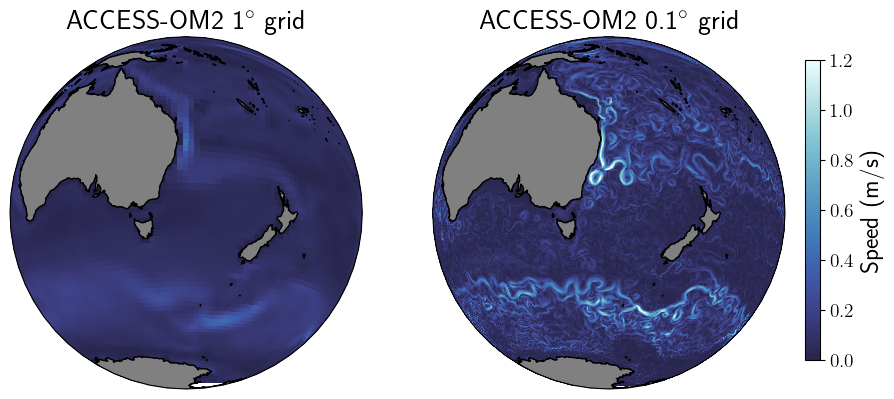

In [10]:
# plot a comparison of SS velocity in Southern Ocean
fig = plt.figure(figsize=(10,6))

central_longitude = 155.0
central_latitude = -40.0
satellite_height = 3300000

ax1 = plt.subplot(1, 2, 1, projection=ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height))
ax1.add_feature(land_50m)
ax1.coastlines(resolution='50m')

p1=speed1.fillna(0).isel(st_ocean = 0).isel(time = 0).plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False,vmin=0,vmax=1.2,cmap=newcmap,transform=ccrs.PlateCarree())

# ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
# cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
# cb.ax.set_ylabel('SST (°C)');
ax1.set_title('ACCESS-OM2 1$^\circ$ grid', fontsize = 20)
ax2 = plt.subplot(1,2,2,projection=ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height))
ax2.add_feature(land_50m)
ax2.coastlines(resolution='50m')

p1=speed01.fillna(0).sel(st_ocean = 50, method = 'nearest').isel(time = 0).plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False,vmin=0,vmax=1.2,cmap=newcmap,transform=ccrs.PlateCarree())
ax2.set_title('ACCESS-OM2 0.1$^\circ$ grid',fontsize = 20)

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Speed (m/s)',fontsize = 18);
cb.ax.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('model_comparison.png',dpi = 600, transparent = True)

# Animate this speed for 0.1 degree model
using code from
https://climate-cms.org/2019/09/03/python-animation.html

In [20]:
v01 = cc.querying.getvar(expt01, 'v', session, ncfile='%daily%', start_time = start_time,end_time=end_time)
v01 = v01.sel(time = slice('2170-01-01','2170-12-31'))
u01 = cc.querying.getvar(expt01, 'u', session, ncfile='%daily%', start_time = start_time,end_time=end_time)
u01 = u01.sel(time = slice('2170-01-01','2170-12-31'))

speed01 = np.sqrt(v01**2+u01**2)



In [21]:
from matplotlib import pyplot as plt, animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display

In [22]:
# this is to make sure there is no size limit
import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 2**128

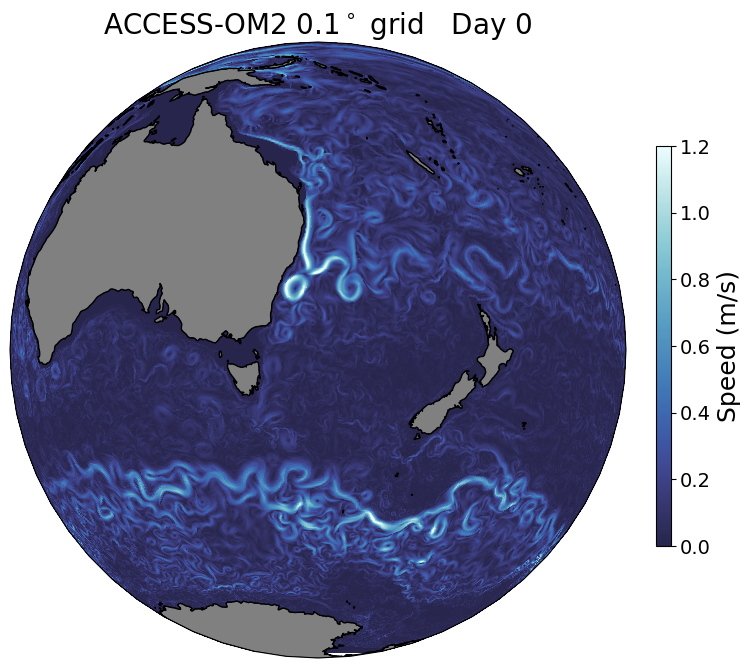

In [23]:
# Get a handle on the figure and the axes

# Plot the initial frame. 

fig = plt.figure(figsize=(10,8))

central_longitude = 155.0
central_latitude = -40.0
satellite_height = 3300000

ax1 = plt.axes(projection=ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height))
ax1.add_feature(land_50m)
ax1.coastlines(resolution='50m')

cax=speed01[0,:,:].fillna(0).sel(st_ocean = 100, method = 'nearest').plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False,vmin=0,vmax=1.2,cmap=newcmap,transform=ccrs.PlateCarree())

ax_cb = plt.axes([0.85, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Speed (m/s)',fontsize = 18);
cb.ax.tick_params(labelsize=14)
ax1.set_title('')

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(speed01[frame,:,:].fillna(0).sel(st_ocean = 100, method = 'nearest').values.flatten())
    ax1.set_title("ACCESS-OM2 0.1$^\circ$ grid   Day " + str(frame),fontsize = 20)

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=365,       # Could also be iterable or list
    interval=50     # ms between frames
)

In [36]:
#turn it into playable HTML
#HTML(ani.to_jshtml())

In [24]:
#save!
ani.save('/g/data/x77/cy8964/Honours/video/speed_01v2.mp4',dpi = 300)
display(HTML("<video controls><source src='/g/data/x77/cy8964/Honours/video/speed_01.mp4' type='video/mp4'></video>"))